In [1]:
import pytensor.tensor as pt
from pytensor.printing import debugprint
from pytensor import function
import pymc as pm
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from nltk.grammar import PCFG
from lossy_tensor import ProgressiveNoiseModel
import grammars

In [2]:
pcfg_russian = PCFG.fromstring(
    grammars.gen_russian_grammar_exp2(
        p_src = 0.58,
        p_src_local = 0.99,
        p_src_case_marked = 0.9,
        p_orc_local = 0.36,
        p_orc_case_marked = 0.83,
        p_one_arg = 0.97,
        p_adj_interveners = 0.16,
        p_one_adj = 0.95
    )
)

true_intercept = np.float64(200)
true_F = np.float64(10)
true_sigma = np.float64(0.1)

true_delta = np.float64(0.7)
true_nu = np.float64(0.5)
model = ProgressiveNoiseModel(pcfg_russian, true_delta, true_nu)

true_vals = [true_intercept, true_F, true_sigma, true_delta, true_nu]

sequences = ["RPNom V DO", "RPNom DO V", "RPAcc V Subj", "RPAcc Subj V"]
sequences = [sequence.split() for sequence in sequences]

calculator = model.gen_processing_difficulty_calculator(sequences)

In [ ]:
n = 100

with pm.Model() as generative_model:
    print("Initialising generative model...")
    tic = time.perf_counter()

    D = pm.Deterministic("D", model.processing_difficulty(sequences, true_delta, true_nu))
    true_Sigma = true_sigma ** 2 * np.eye(len(sequences))

    rt = pm.MvNormal("rt", true_intercept + true_F * D, true_Sigma)

    print(f"Finished generative model initialisation in {time.perf_counter() - tic} seconds.")

    print(f"Generating {n} data points...")
    tic = time.perf_counter()
    data = pm.draw(rt, n, random_seed = 12)
    t = time.perf_counter() - tic
    print("Finished drawing data.")

Initialising generative model...
Finished generative model initialisation in 0.2117316000003484 seconds.
Generating 100 data points...
Finished drawing data.


In [ ]:
with pm.Model() as deterministic_model:
    print("Initialising predictive model...")
    tic = time.perf_counter()

    alpha = pm.Normal("alpha", 225, 30)
    F = pm.Normal("F", 4, 1)
    sigma = pm.TruncatedNormal("sigma", mu = 0, sigma = 1, lower = 0)
    Sigma = sigma ** 2 * pt.eye(len(sequences))

    delta = pm.Beta("delta", 1, 1)
    nu = pm.Beta("nu", 1, 1)

    D = pm.Deterministic("D", model.processing_difficulty(sequences, delta, nu))

    rt = pm.MvNormal("rt", alpha + F * D, Sigma, observed = data)

    print(f"Finished predictive model initialisation in {time.perf_counter() - tic} seconds.")

    print("Fitting model...")
    tic = time.perf_counter()
    idata = pm.sample()
    t = time.perf_counter() - tic
    print(f"Fitted model in {t} seconds.")

Initialising predictive model...
Finished predictive model initialisation in 18.65931619999901 seconds.
Fitting model...


Initializing NUTS using jitter+adapt_diag...
c:\Users\Johan\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, F, sigma, delta, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 209 seconds.


Fitted model in 914.2912281999998 seconds.


In [7]:
sampled_variables = {}

for variable in ["alpha", "F", "sigma", "delta", "nu"]:
    sampled_variables[variable] = idata.posterior[variable].values.flatten()

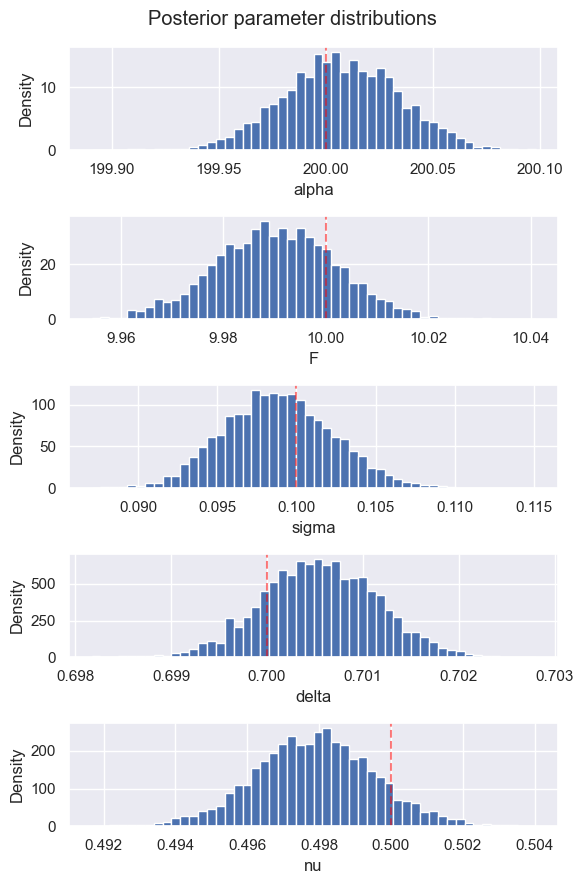

In [8]:
fig, axes = plt.subplots(len(sampled_variables), 1, layout = "tight")

for (axis, (variable, samples), true_val) in zip(axes, sampled_variables.items(), true_vals):
    axis.hist(samples, bins = 50, density = True)
    axis.axvline(true_val, color = "red", alpha = 0.5, linestyle = "dashed")
    axis.set_xlabel(variable)
    axis.set_ylabel("Density")

fig.suptitle("Posterior parameter distributions")

fig.set_size_inches(6, 9)

plt.show();